## Third Approach: Re-sampling with SMOTE

In this approach, we will use the **SMOTE (Synthetic Minority Over-sampling Technique)** algorithm to balance the dataset. SMOTE generates synthetic samples for the minority class to balance the dataset. First, we will oversample the minority class **Enrolled**, then we will train a model using the balanced dataset. Additionally, we will perform other experiments, such as oversampling the other minority class **Dropout** and undersampling the majority class **Graduated**.

The SMOTE algorithm is described in the following paper: [SMOTE: Synthetic Minority Over-sampling Technique](https://www.jair.org/index.php/jair/article/view/10302/24590). In this paper, the authors present the algorithm and demonstrate how this technique of oversampling the minority class is superior to traditional oversampling techniques, which simply duplicate the samples of the minority class.

Below is the pseudo-code for a two-class problem:

```julia
Algorithm SMOTE(T, N, k)
Input:
    T = Number of minority class samples
    N = Percentage of oversampling (SMOTE percentage)
    k = Number of nearest neighbors

Output:
    (N/100) * T synthetic minority class samples

1. If N is less than 100%, randomize the minority class samples, as only a random percentage of them will be SMOTEd.
2. If N < 100 then
    3. Randomize the T minority class samples
    4. T = (N / 100) * T
    5. N = 100
6. End if
7. N = (int)(N / 100) * T  (*The amount of SMOTE is assumed to be in integral multiples of 100.*)
8. k = Number of nearest neighbors
9. numattrs = Number of attributes
10. Sample[][]: Array for original minority class samples
11. newindex: Counter for number of synthetic samples, initialized to 0
12. Synthetic[][]: Array for synthetic samples

13. For i = 1 to T
    14. Compute k nearest neighbors for sample i, and save the indices in nnarray
    15. Populate(N, i, nnarray)
16. End for

Function Populate(N, i, nnarray):
17. While N > 0
    18. Choose a random number between 1 and k, call it nn. This step selects one of the k nearest neighbors of sample i.
    19. For each attribute (attr) from 1 to numattrs:
        20. Compute the difference: dif = Sample[nnarray[nn]][attr] - Sample[i][attr]
        21. Compute a random gap: gap = random number between 0 and 1
        22. Synthetic[newindex][attr] = Sample[i][attr] + gap * dif
    20. End for
    23. Increment newindex
    24. Decrement N
25. End while

26. Return synthetic samples
End of pseudo-code.
```


### Description of the used models

To be able to compare the results with the first and second approaches, we will use the same configuration of hyperparameters for the models:

- **ANN**:
  - Hidden layers: 1, number of neurons in the hidden layer: $[16, 32, 64]$.
  - Hidden layers: 2, number of neurons in the hidden layers $[(16, 16), (32, 16), (32, 32), (64, 32), (64, 64)]$.
- **Decision Tree**:
  - Maximum depth of the tree $\in \{3, 5, 10, 15, 20, \text{None}\}$
- **SVM**:
  - Kernel $\in \{\text{linear}, \text{poly}, \text{rbf}, \text{sigmoid}\}$
  - C $\in \{0.1, 1, 10\}$
- **KNN\***:
  - $k \in \{1, 3, 5, 7, 9, 11, 13, 15\}$

After training the models, we will train an ensemble model with the three best models. The method used to combine the models will be:

- **Majority voting**
- **Weighted voting**
- **Stacking** (using a logistic regression as the meta-model)


**Index**

- [Data loading](#Data-loading)
- [SMOTE experiments](#SMOTE-experiments)
- [Individual models](#Individual-models)
  - [ANN](#ANN)
  - [Decision Tree](#Decision-Tree)
  - [Support Vector Machine](#Support-Vector-Machine)
  - [K-Nearest Neighbors](#K-Nearest-Neighbors)
- [Ensemble model](#Ensemble-model)
  - [Majority voting](#Majority-voting)
  - [Weighted voting](#Weighted-voting)
  - [Naive Bayes](#Naive-Bayes)
  - [Stacking](#Stacking)


## Data loading


In [1]:
using DataFrames
using CSV
using Random
using Serialization

In [2]:
# Load custom functions from provided files
include("preprocessing.jl")
include("metrics.jl")
include("training.jl")
include("plotting.jl")

generateComparisonTable (generic function with 2 methods)

In [5]:
# Set the random seed for reproducibility
Random.seed!(42)

# Load the dataset
dataset_path = "dataset.csv"
data = CSV.read(dataset_path, DataFrame);

# Separate features and target
target_column = :Target
inputs = select(data, Not(target_column))
targets = data[!, target_column];

inputs = Float32.(Matrix(inputs));

In [6]:
# Split into training and testing sets
Random.seed!(42)
train_indices, test_indices = holdOut(inputs, targets, 0.15)
test_inputs = inputs[test_indices, :]
test_targets = targets[test_indices]
inputs = inputs[train_indices, :]
targets = targets[train_indices];

In [7]:
function count_classes(targets::AbstractArray{<:Any,1})
    counts = Dict{Any, Int}()
    for target in targets
        counts[target] = get(counts, target, 0) + 1
    end
    return counts
end

# Ensure the frequency of each class is similar in the training and testing sets
count_train = count_classes(targets)
println("Training set distribution: ")
for (label, count) in count_train
    println("Label: ", label, ", Frequency ratio: ", count / length(targets))
end

count_test = count_classes(test_targets)
println("Testing set distribution: ")
for (label, count) in count_test
    println("Label: ", label, ", Frequency ratio: ", count / length(test_targets))
end

Training set distribution: 
Label: Enrolled, Frequency ratio: 0.17819148936170212
Label: Graduate, Frequency ratio: 0.5066489361702128
Label: Dropout, Frequency ratio: 0.3151595744680851
Testing set distribution: 
Label: Enrolled, Frequency ratio: 0.18674698795180722
Label: Graduate, Frequency ratio: 0.4578313253012048
Label: Dropout, Frequency ratio: 0.35542168674698793


In [ ]:
# Define the number of folds for cross-validation and obtain the indices
Random.seed!(42)
k = 5
N = size(inputs, 1)
fold_indices = crossValidation(targets, k)
metrics_to_save = [:accuracy, :precision, :recall, :f1_score];

## SMOTE experiments

In the first approach we see that we detected some problems in some metrics because of the imbalance of the dataset. For example, for the scikit-learn ANN model, we obtained so bad f1-score values for the third class, `Enrolled`:

<div style="display: flex; justify-content: center;">
<image src="plots/Approach1/scikit_ANN/class_results/f1_score_performance_class_3_bar.png" width="50%">
</div>

To address this problem, we will use the SMOTE algorithm to balance the dataset. We will conduct 5 experiments:

- Oversampling the minority class `Enrolled` at 200%.
- Oversampling the minority class `Enrolled` at 300%.
- Oversampling the minority class `Dropout` at 200% and oversampling the minority class `Enrolled` at 200%.
- Oversampling the minority class `Dropout` at 200% and oversampling the minority class `Enrolled` at 300%.
- Oversampling the minority class `Enrolled` at 200% and undersampling the majority class `Graduated` at 50%.

We are going to fix the number of nearest neighbors to 5.

To avoid retraining all the models multiple times, we will perform the experiments only with the base models: ANN, Decision Tree, SVM, and KNN, using the best hyperparameters identified in the first approach. Subsequently, we will train the models in the same manner as in the first approach, but with the balanced dataset that yielded the best results.


In [5]:
target_column = :Target
println("\nClass Distribution:")
println(combine(groupby(data, target_column), nrow => :Count))


Class Distribution:
3×2 DataFrame
 Row │ Target    Count 
     │ String15  Int64 
─────┼─────────────────
   1 │ Dropout    1421
   2 │ Graduate   2209
   3 │ Enrolled    794


In [15]:
smote_percentages = [
  Dict("Enrolled" => 200),
  Dict("Enrolled" => 300),
  Dict("Enrolled" => 200, "Dropout" => 200),
  Dict("Enrolled" => 300, "Dropout" => 200),
  Dict("Enrolled" => 200, "Graduate" => 50),
  Dict{String, Int64}()
]
k = 5

open("warnings.log", "w") do file
  redirect_stderr(file) do # redirect warnings associated with joblib
    for (i, smote_percentage) in enumerate(smote_percentages)
      println("\nSmote percentages: ", smote_percentage)
      balanced_inputs, balanced_targets = smote(inputs, targets, smote_percentage, k)
      println("Number of instances: ", size(balanced_targets)[1])
      println("Elements of class Dropout: ", sum(balanced_targets .== "Dropout"))
      println("Elements of class Graduate: ", sum(balanced_targets .== "Graduate"))
      println("Elements of class Enrolled: ", sum(balanced_targets .== "Enrolled"))
    end
  end
end


Smote percentages: Dict("Enrolled" => 200)
Number of instances: 5218
Elements of class Dropout: 1421
Elements of class Graduate: 2209
Elements of class Enrolled: 1588

Smote percentages: Dict("Enrolled" => 300)
Number of instances: 6012
Elements of class Dropout: 1421
Elements of class Graduate: 2209
Elements of class Enrolled: 2382

Smote percentages: Dict("Enrolled" => 200, "Dropout" => 200)
Number of instances: 6639
Elements of class Dropout: 2842
Elements of class Graduate: 2209
Elements of class Enrolled: 1588

Smote percentages: Dict("Enrolled" => 300, "Dropout" => 200)
Number of instances: 7433
Elements of class Dropout: 2842
Elements of class Graduate: 2209
Elements of class Enrolled: 2382

Smote percentages: Dict("Enrolled" => 200, "Graduate" => 50)
Number of instances: 4113
Elements of class Dropout: 1421
Elements of class Graduate: 1104
Elements of class Enrolled: 1588

Smote percentages: Dict{String, Int64}()
Number of instances: 4424
Elements of class Dropout: 1421
Elemen

In [26]:
# Best configurations
topology = [32, 16]
topology_scikit_ann = [16, 16]
max_depth = 5
n_neighbors = 15
kernel = "linear"
C = 0.1

# ANN
hyperparameters_ann = Dict(
  "topology" => topology,
  "learningRate" => 0.01,
  "maxEpochs" => 100,
  "repetitionsTraining" => 10,
  "validationRatio" => 0.15,
  "maxEpochsVal" => 10,
  "minLoss" => 0.0001
)

# scikitANN
hyperparameters_scikit_ann = Dict(
  :hidden_layer_sizes => topology_scikit_ann,
  :learning_rate_init => 0.01,
  :max_iter => 100,
  :early_stopping => true,
  :tol => 0,
  :validation_fraction => 0.15,
  :n_iter_no_change => 10,
  :epsilon => 0.0001,
  :repetitionsTraining => 10
)

# DT
hyperparameters_dt = Dict(
  :max_depth => max_depth,
  :criterion => "gini",
  :min_samples_split => 2,
)

# SVM
hyperparameters_svm = Dict(
  :kernel => kernel,
  :C => C,
  :gamma => "auto",
  :probability => true,
)

# KNN
hyperparameters_knn = Dict(
  :n_neighbors => n_neighbors,
  :weights => "uniform",
  :metric => "euclidean",
)

# Define the hyperparameters for smote
k = 5
smote_percentages = [
  Dict("Enrolled" => 200),
  Dict("Enrolled" => 300),
  Dict("Enrolled" => 200, "Dropout" => 200),
  Dict("Enrolled" => 300, "Dropout" => 200),
  Dict("Enrolled" => 200, "Graduate" => 50),
  Dict{String, Int64}()
];

In [27]:
Random.seed!(42)

general_results_ann = []
class_results_ann = []
general_results_scikit_ann = []
class_results_scikit_ann = []
general_results_dt = []
class_results_dt = []
general_results_svm = []
class_results_svm = []
general_results_knn = []
class_results_knn = []

open("warnings.log", "w") do file
  redirect_stderr(file) do # redirect warnings associated with joblib
    for smote_percentage in smote_percentages
      println("\nSmote percentage: ", smote_percentage)

      # ANN
      println("ANN")
      gr, cr = modelCrossValidation(
        :ANN,
        hyperparameters_ann,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )
      push!(general_results_ann, gr)
      push!(class_results_ann, cr)

      # Scikit ANN
      println("scikitANN")
      gr, cr = modelCrossValidation(
        :scikit_ANN,
        hyperparameters_scikit_ann,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )

      push!(general_results_scikit_ann, gr)
      push!(class_results_scikit_ann, cr)

      # DT
      println("DT")
      gr, cr = modelCrossValidation(
        :DT,
        hyperparameters_dt,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )
      push!(general_results_dt, gr)
      push!(class_results_dt, cr)

      # SVM
      println("SVM")
      gr, cr = modelCrossValidation(
        :SVC,
        hyperparameters_svm,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )
      push!(general_results_svm, gr)
      push!(class_results_svm, cr)

      # KNN
      println("KNN")
      gr, cr = modelCrossValidation(
        :KNN,
        hyperparameters_knn,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )
      push!(general_results_knn, gr)
      push!(class_results_knn, cr)
    end
  end
end


Smote percentage: Dict("Enrolled" => 200)
ANN
Mean accuracy: 0.50822 ± 0.02835
	Class 1: 0.43097 ± 0.0419
	Class 2: 0.46566 ± 0.02078
	Class 3: 0.76491 ± 0.04178
Mean precision: 0.18839 ± 0.04102
	Class 1: 0.19945 ± 0.01794
	Class 2: 0.22018 ± 0.08935
	Class 3: 0.08006 ± 0.03701
Mean recall: 0.33077 ± 0.04648
	Class 1: 0.52037 ± 0.08918
	Class 2: 0.29361 ± 0.15447
	Class 3: 0.09471 ± 0.06964
Mean f1_score: 0.20975 ± 0.0385
	Class 1: 0.27352 ± 0.03961
	Class 2: 0.22239 ± 0.10223
	Class 3: 0.06032 ± 0.02927
scikitANN
Mean accuracy: 0.83491 ± 0.00627
	Class 1: 0.83475 ± 0.01537
	Class 2: 0.8449 ± 0.00847
	Class 3: 0.82219 ± 0.005
Mean precision: 0.72471 ± 0.00943
	Class 1: 0.76927 ± 0.01832
	Class 2: 0.76085 ± 0.01855
	Class 3: 0.51849 ± 0.03203
Mean recall: 0.75092 ± 0.00711
	Class 1: 0.87735 ± 0.05777
	Class 2: 0.78709 ± 0.04023
	Class 3: 0.25969 ± 0.06684
Mean f1_score: 0.72434 ± 0.00886
	Class 1: 0.81695 ± 0.03024
	Class 2: 0.77019 ± 0.02295
	Class 3: 0.33692 ± 0.05842
DT
Mean accura

### Save the results and analysis


In [28]:
# Save the results
results_folder = "results/"
if !isdir(results_folder)
  mkdir(results_folder)
end

filename = results_folder * "3_smote_results.jl"

parameters = Dict("Enrolled" => [200, 300, 200, 300, 200, 100], "Dropout" => [100, 100, 200, 200, 100, 100], "Graduate" => [100, 100, 100, 100, 50, 100])

# Create a dictionary with the results of ANN, DT, SVM, and KNN
obj = Dict(
  :ANN => Dict(
    "num_trained_models" => length(general_results_ann),
    "parameters" => parameters,
    "general_results" => general_results_ann,
    "class_results" => class_results_ann
  ),
  :scikit_ANN => Dict(
    "num_trained_models" => length(general_results_scikit_ann),
    "parameters" => parameters,
    "general_results" => general_results_scikit_ann,
    "class_results" => class_results_scikit_ann
  ),
  :DT => Dict(
    "num_trained_models" => length(general_results_dt),
    "parameters" => parameters,
    "general_results" => general_results_dt,
    "class_results" => class_results_dt
  ),
  :SVM => Dict(
    "num_trained_models" => length(general_results_svm),
    "parameters" => parameters,
    "general_results" => general_results_svm,
    "class_results" => class_results_svm
  ),
  :KNN => Dict(
    "num_trained_models" => length(general_results_knn),
    "parameters" => parameters,
    "general_results" => general_results_knn,
    "class_results" => class_results_knn
  )
)

# Save the results
open(filename, "w") do file
  serialize(file, obj)
end

In [6]:
results_folder = "results/"
filename = results_folder * "3_smote_results.jl"

# Load the results
loaded_obj = open(filename, "r") do file
  deserialize(file)
end

Dict{Symbol, Dict{String, Any}} with 5 entries:
  :DT         => Dict("class_results"=>Any[[Dict(:recall=>[0.950226, 0.925339, …
  :KNN        => Dict("class_results"=>Any[[Dict(:recall=>[0.864253, 0.877828, …
  :SVM        => Dict("class_results"=>Any[[Dict(:recall=>[0.750877, 0.78169, 0…
  :scikit_ANN => Dict("class_results"=>Any[[Dict(:recall=>[0.899792, 0.817484, …
  :ANN        => Dict("class_results"=>Any[[Dict(:recall=>[0.670175, 0.454225, …

In [7]:
# Generate tables for each algorithm sorted by f1 score
generateAlgorithmTables(loaded_obj, sort_by=:F1_Score, rev=true, output_dir="./tables/Approach3/smote/")


Comparison of Hyperparameter Configurations for DT (Sorted by F1_Score):
┌────────────────────────────────────────────┬──────────┬───────────┬──────────┬──────────┐
│                              Configuration │ Accuracy │ Precision │   Recall │ F1-Score │
├────────────────────────────────────────────┼──────────┼───────────┼──────────┼──────────┤
│ Enrolled: 100, Graduate: 100, Dropout: 100 │ 0.841457 │   0.75336 │ 0.760452 │ 0.745818 │
│ Enrolled: 200, Graduate: 100, Dropout: 100 │ 0.824279 │  0.700295 │ 0.737853 │ 0.696531 │
│ Enrolled: 300, Graduate: 100, Dropout: 100 │ 0.821899 │  0.691041 │ 0.733333 │ 0.686796 │
│ Enrolled: 200, Graduate: 100, Dropout: 200 │ 0.689202 │   0.64063 │ 0.545763 │ 0.458252 │
│ Enrolled: 300, Graduate: 100, Dropout: 200 │ 0.654276 │  0.648208 │ 0.531073 │ 0.419657 │
│  Enrolled: 200, Graduate: 50, Dropout: 100 │ 0.591261 │  0.633994 │ 0.414496 │ 0.377558 │
└────────────────────────────────────────────┴──────────┴───────────┴──────────┴──────────┘
Result

Based on the results presented in the tables, the best SMOTE configuration involves oversampling the minority class, `Enrolled`, by 300%, while keeping the majority class, `Graduated`, and the other class, `Dropout`, unchanged. This conclusion is drawn from the mean F1-score, the metric of primary interest in this analysis.

However, it is important to highlight that, except for the KNN model, applying SMOTE tends to degrade the performance compared to the initial approach without balancing the dataset. This decline can be attributed to the synthetic samples generated by the SMOTE algorithm, which may introduce noise rather than meaningful information for balancing the dataset. This underscores a critical limitation of SMOTE: its effectiveness is highly dependent on the characteristics of the dataset and the specific models used.

Another noteworthy point is the dataset's high dimensionality, which may lead SMOTE to generate synthetic samples that fail to benefit the models. High dimensionality can obscure meaningful patterns and hinder the generation of useful synthetic data. As a potential improvement, applying feature selection techniques to reduce the number of attributes before applying SMOTE could lead to better outcomes. This refined approach will be explored in the next steps of the analysis.


In [7]:
# Best smote configuration
smotePercentages = Dict("Enrolled" => 300)
smoteNeighbors = 5

5

## Individual models

Next, we will train the individual models with the best hyperparameters identified in the first approach, but using the balanced dataset that yielded the best results in the SMOTE experiments.

### ANN

We are going to use the our implementation for Artificial Neural Networks. To augment the robustness of the model, we will train each architecture 5 times with each fold of the cross-validation.

We trained 8 models, 3 with one hidden layer and 5 with two hidden layers. The used topology for the hidden layers are:

- **One hidden layer**:
  - 16 neurons
  - 32 neurons
  - 64 neurons
- **Two hidden layers**:
  - (16, 16) neurons
  - (32, 16) neurons
  - (32, 32) neurons
  - (64, 32) neurons
  - (64, 64) neurons


In [8]:
# Set the random seed for reproducibility
Random.seed!(42)

topologies = [[16], [32], [64], [16, 16], [32, 16], [32, 32], [64, 32], [64, 64]]

general_results_ann = []
class_results_ann = []

for topology in topologies
  hyperparameters = Dict(
    "topology" => topology,
    "learningRate" => 0.01,
    "maxEpochs" => 100,
    "repetitionsTraining" => 10,
    "validationRatio" => 0.15,
    "maxEpochsVal" => 10,
    "minLoss" => 0.0001
  )

  println("Training ANN with topology: ", topology)

  gr, cr = modelCrossValidation(
    :ANN,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    verbose=false,
    applySmote=true,
    smotePercentages=smotePercentages,
    smoteNeighbors=smoteNeighbors
  )

  push!(general_results_ann, gr)
  push!(class_results_ann, cr)
end

Training ANN with topology: [16]


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(34 => 16, σ)
│   summary(x) = 34×4089 adjoint(::Matrix{Float64}) with eltype Float64
└ @ Flux /home/markel/.julia/packages/Flux/vwk6M/src/layers/stateless.jl:59


Mean accuracy: 0.69571 ± 0.18204
	Class 1: 0.71881 ± 0.19474
	Class 2: 0.67378 ± 0.19473
	Class 3: 0.71535 ± 0.12716
Mean precision: 0.54407 ± 0.2383
	Class 1: 0.587 ± 0.26759
	Class 2: 0.59238 ± 0.25377
	Class 3: 0.33277 ± 0.14331
Mean recall: 0.55397 ± 0.25725
	Class 1: 0.60642 ± 0.24957
	Class 2: 0.59786 ± 0.39513
	Class 3: 0.3379 ± 0.11117
Mean f1_score: 0.52234 ± 0.27642
	Class 1: 0.57639 ± 0.28565
	Class 2: 0.57025 ± 0.35296
	Class 3: 0.29224 ± 0.06037
Training ANN with topology: [32]
Mean accuracy: 0.55783 ± 0.15533
	Class 1: 0.55094 ± 0.17963
	Class 2: 0.53002 ± 0.16457
	Class 3: 0.64748 ± 0.10998
Mean precision: 0.36065 ± 0.21046
	Class 1: 0.34016 ± 0.23935
	Class 2: 0.40864 ± 0.21963
	Class 3: 0.26364 ± 0.14519
Mean recall: 0.36422 ± 0.21761
	Class 1: 0.45173 ± 0.22092
	Class 2: 0.30606 ± 0.33504
	Class 3: 0.36886 ± 0.12442
Mean f1_score: 0.30721 ± 0.23599
	Class 1: 0.36137 ± 0.24086
	Class 2: 0.29594 ± 0.30383
	Class 3: 0.2413 ± 0.06593
Training ANN with topology: [64]
Mean 

## ScikitLearn ANN

We will use the MLPClassifier from ScikitLearn to train the ANN models. The hyperparameters used in the models are the same as in the previous ANN implementation:

We trained 8 models, 3 with one hidden layer and 5 with two hidden layers. The used topology for the hidden layers are:

- **One hidden layer**:
  - 16 neurons
  - 32 neurons
  - 64 neurons
- **Two hidden layers**:
  - (16, 16) neurons
  - (32, 16) neurons
  - (32, 32) neurons
  - (64, 32) neurons
  - (64, 64) neurons


In [9]:
# Set the random seed for reproducibility
Random.seed!(42)
# Best smote configuration
smotePercentages = Dict("Enrolled" => 300)
smoteNeighbors = 5

topologies = [[16], [32], [64], [16, 16], [32, 16], [32, 32], [64, 32], [64, 64]]

general_results_scikit_ann = []
class_results_scikit_ann = []

for topology in topologies
  hyperparameters = Dict(
    :hidden_layer_sizes => topology,
    :learning_rate_init => 0.01,
    :max_iter => 100,
    :early_stopping => true,
    :tol => 0,
    :validation_fraction => 0.15,
    :n_iter_no_change => 10,
    :epsilon => 0.0001,
    :repetitionsTraining => 10
  )

  println("Training ANN with topology: ", topology)

  gr, cr = modelCrossValidation(
    :scikit_ANN,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    verbose=false,
    applySmote=true,
    smotePercentages=smotePercentages,
    smoteNeighbors=smoteNeighbors
  )

  push!(general_results_scikit_ann, gr)
  push!(class_results_scikit_ann, cr)
end

Training ANN with topology: [16]
Mean accuracy: 0.83524 ± 0.00769
	Class 1: 0.84181 ± 0.01106
	Class 2: 0.83778 ± 0.01271
	Class 3: 0.81987 ± 0.01699
Mean precision: 0.72679 ± 0.01672
	Class 1: 0.77623 ± 0.0134
	Class 2: 0.75052 ± 0.05534
	Class 3: 0.51265 ± 0.10917
Mean recall: 0.74973 ± 0.01219
	Class 1: 0.84286 ± 0.07286
	Class 2: 0.77923 ± 0.14036
	Class 3: 0.32807 ± 0.11953
Mean f1_score: 0.73041 ± 0.01322
	Class 1: 0.8066 ± 0.03749
	Class 2: 0.75965 ± 0.1005
	Class 3: 0.39374 ± 0.11542
Training ANN with topology: [32]
Mean accuracy: 0.83459 ± 0.00659
	Class 1: 0.83897 ± 0.01286
	Class 2: 0.83817 ± 0.01299
	Class 3: 0.8203 ± 0.01205
Mean precision: 0.7232 ± 0.01591
	Class 1: 0.7694 ± 0.02107
	Class 2: 0.74314 ± 0.03505
	Class 3: 0.51537 ± 0.06015
Mean recall: 0.74872 ± 0.01132
	Class 1: 0.84701 ± 0.06988
	Class 2: 0.76814 ± 0.07793
	Class 3: 0.3183 ± 0.07936
Mean f1_score: 0.72646 ± 0.01218
	Class 1: 0.80401 ± 0.04027
	Class 2: 0.74914 ± 0.05587
	Class 3: 0.38437 ± 0.07033
Trainin

### Decision Tree

The Decision Tree model will be trained with the following hyperparameters:

- Maximum depth of the tree $\in \{3, 5, 10, 15, 20, \text{nothing}\}$


In [10]:
# Set the random seed for reproducibility (smote is not deterministic)
Random.seed!(42)
# Best smote configuration
smotePercentages = Dict("Enrolled" => 300)
smoteNeighbors = 5

max_depths = [3, 5, 10, 15, 20, nothing]

general_results_dt = []
class_results_dt = []

for max_depth in max_depths
  hyperparameters = Dict(
    :max_depth => max_depth,
    :criterion => "gini",
    :min_samples_split => 2,
  )

  println("Training DT model with max_depth: ", max_depth)

  gr, ct = modelCrossValidation(
    :DT,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    verbose=false
  )

  push!(general_results_dt, gr)
  push!(class_results_dt, ct)
end

Training DT model with max_depth: 3
Mean accuracy: 0.82239 ± 0.00886
	Class 1: 0.82435 ± 0.03155
	Class 2: 0.8255 ± 0.0243
	Class 3: 0.81939 ± 0.02309
Mean precision: 0.73254 ± 0.01711
	Class 1: 0.793 ± 0.06498
	Class 2: 0.73257 ± 0.16399
	Class 3: 0.53936 ± 0.16781
Mean recall: 0.73462 ± 0.00832
	Class 1: 0.80915 ± 0.13539
	Class 2: 0.72364 ± 0.19998
	Class 3: 0.41 ± 0.18145
Mean f1_score: 0.72291 ± 0.01767
	Class 1: 0.79132 ± 0.04483
	Class 2: 0.71912 ± 0.15232
	Class 3: 0.45831 ± 0.17659
Training DT model with max_depth: 5
Mean accuracy: 0.83213 ± 0.00849
	Class 1: 0.8309 ± 0.03625
	Class 2: 0.84788 ± 0.02588
	Class 3: 0.82617 ± 0.00856
Mean precision: 0.74655 ± 0.01103
	Class 1: 0.79043 ± 0.07879
	Class 2: 0.82536 ± 0.06329
	Class 3: 0.52823 ± 0.04545
Mean recall: 0.75248 ± 0.01035
	Class 1: 0.85111 ± 0.15039
	Class 2: 0.78715 ± 0.13444
	Class 3: 0.31852 ± 0.07523
Mean f1_score: 0.73416 ± 0.01564
	Class 1: 0.80702 ± 0.03569
	Class 2: 0.79627 ± 0.03919
	Class 3: 0.39288 ± 0.06056
Tr

### Support Vector Machine

The SVM model will be trained with all the possible combinations of the following hyperparameters:

- Kernel $\in \{\text{linear}, \text{poly}, \text{rbf}, \text{sigmoid}\}$
- C $\in \{0.1, 1, 10\}$


In [11]:
# Set the random seed for reproducibility (smote is not deterministic)
Random.seed!(42)
# Best smote configuration
smotePercentages = Dict("Enrolled" => 300)
smoteNeighbors = 5

kernel_C = [
  ("linear", 0.1),
  ("linear", 1.0),
  ("linear", 10.0),
  ("poly", 0.1),
  ("poly", 1.0),
  ("poly", 10.0),
  ("rbf", 0.1),
  ("rbf", 1.0),
  ("rbf", 10.0),
  ("sigmoid", 0.1),
  ("sigmoid", 1.0),
  ("sigmoid", 10.0)
]

general_results_svm = []
class_results_svm = []

for (kernel, C) in kernel_C
  hyperparameters = Dict(
    :kernel => kernel,
    :C => C,
    :gamma => "auto",
    :probability => true,
  )

  println("Training SVM model with kernel: ", kernel, " and C: ", C)

  gr, cr = modelCrossValidation(
    :SVC,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    verbose=false,
    applySmote=true,
    smotePercentages=smotePercentages,
    smoteNeighbors=smoteNeighbors
  )

  push!(general_results_svm, gr)
  push!(class_results_svm, cr)
end

Training SVM model with kernel: linear and C: 0.1
Mean accuracy: 0.83932 ± 0.0053
	Class 1: 0.84313 ± 0.01768
	Class 2: 0.84381 ± 0.01783
	Class 3: 0.82437 ± 0.01836
Mean precision: 0.74213 ± 0.00892
	Class 1: 0.80216 ± 0.03251
	Class 2: 0.73873 ± 0.13465
	Class 3: 0.5517 ± 0.14857
Mean recall: 0.75565 ± 0.00773
	Class 1: 0.83672 ± 0.11782
	Class 2: 0.73351 ± 0.24722
	Class 3: 0.42062 ± 0.16478
Mean f1_score: 0.74222 ± 0.00703
	Class 1: 0.81364 ± 0.04237
	Class 2: 0.72924 ± 0.19089
	Class 3: 0.47555 ± 0.1599
Training SVM model with kernel: linear and C: 1.0
Mean accuracy: 0.83952 ± 0.00678
	Class 1: 0.84561 ± 0.0156
	Class 2: 0.8411 ± 0.01486
	Class 3: 0.8246 ± 0.01947
Mean precision: 0.74041 ± 0.01117
	Class 1: 0.80127 ± 0.02355
	Class 2: 0.73413 ± 0.12394
	Class 3: 0.55195 ± 0.14812
Mean recall: 0.75566 ± 0.01072
	Class 1: 0.84144 ± 0.1101
	Class 2: 0.73431 ± 0.24441
	Class 3: 0.41198 ± 0.17172
Mean f1_score: 0.74151 ± 0.00889
	Class 1: 0.81671 ± 0.04306
	Class 2: 0.7272 ± 0.18546
	C

### K-Nearest Neighbors

The KNN model will be trained with the following hyperparameters:

- $k \in \{1, 3, 5, 7, 9, 11, 13, 15\}$


In [12]:
# Set the random seed for reproducibility (smote is not deterministic)
Random.seed!(42)

# Best smote configuration
smotePercentages = Dict("Enrolled" => 300)
smoteNeighbors = 5

n_neighbors = [1, 3, 5, 7, 9, 11, 13, 15]

general_results_knn = []
class_results_knn = []

open("warnings.log", "w") do file
  redirect_stderr(file) do # redirect warnings associated with joblib
    for n in n_neighbors
      hyperparameters = Dict(
        :n_neighbors => n,
        :weights => "uniform",
        :metric => "euclidean",
      )

      println("Training KNN model with n_neighbors: ", n)

      gr, cr = modelCrossValidation(
        :KNN,
        hyperparameters,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        verbose=false,
        applySmote=true,
        smotePercentages=smotePercentages,
        smoteNeighbors=smoteNeighbors
      )

      push!(general_results_knn, gr)
      push!(class_results_knn, cr)
    end
  end
end

Training KNN model with n_neighbors: 1
Mean accuracy: 0.77664 ± 0.01203
	Class 1: 0.79067 ± 0.02238
	Class 2: 0.77421 ± 0.02737
	Class 3: 0.77872 ± 0.03068
Mean precision: 0.66157 ± 0.01889
	Class 1: 0.72865 ± 0.01489
	Class 2: 0.57783 ± 0.20754
	Class 3: 0.51201 ± 0.18747
Mean recall: 0.6718 ± 0.01894
	Class 1: 0.71791 ± 0.09294
	Class 2: 0.58211 ± 0.26221
	Class 3: 0.47809 ± 0.23293
Mean f1_score: 0.66456 ± 0.01895
	Class 1: 0.72137 ± 0.05245
	Class 2: 0.57785 ± 0.23262
	Class 3: 0.49249 ± 0.20987
Training KNN model with n_neighbors: 3
Mean accuracy: 0.78536 ± 0.012
	Class 1: 0.78843 ± 0.02552
	Class 2: 0.79928 ± 0.02234
	Class 3: 0.77126 ± 0.02833
Mean precision: 0.67907 ± 0.0167
	Class 1: 0.74833 ± 0.01498
	Class 2: 0.67278 ± 0.14388
	Class 3: 0.44069 ± 0.18466
Mean recall: 0.67949 ± 0.02237
	Class 1: 0.74178 ± 0.0821
	Class 2: 0.62528 ± 0.16294
	Class 3: 0.46223 ± 0.21665
Mean f1_score: 0.67778 ± 0.01892
	Class 1: 0.74368 ± 0.04803
	Class 2: 0.64688 ± 0.15042
	Class 3: 0.45065 ± 0

### Save the results

The filename with the results of individual models of this first approach will be `3_individual_results.jl`.


In [13]:
results_folder = "results/"
if !isdir(results_folder)
  mkdir(results_folder)
end

filename = results_folder * "3_individual_results.jl"

# Separete the kernel and C values of the hyperparameter list for SVM
kernels = [item[1] for item in kernel_C]
C_values = [item[2] for item in kernel_C]

# Create a dictionary with the results of ANN, DT, SVM, and KNN
obj = Dict(
  :ANN => Dict(
    "num_trained_models" => length(general_results_ann),
    "parameters" => Dict(
      "topology" => topologies
    ),
    "general_results" => general_results_ann,
    "class_results" => class_results_ann
  ),
  :scikit_ANN => Dict(
    "num_trained_models" => length(general_results_scikit_ann),
    "parameters" => Dict(
      "hidden_layer_sizes" => topologies
    ),
    "general_results" => general_results_scikit_ann,
    "class_results" => class_results_scikit_ann
  ),
  :DT => Dict(
    "num_trained_models" => length(general_results_dt),
    "parameters" => Dict(
      "max_depth" => max_depths
    ),
    "general_results" => general_results_dt,
    "class_results" => class_results_dt
  ),
  :SVM => Dict(
    "num_trained_models" => length(general_results_svm),
    "parameters" => Dict(
      "kernel" => kernels,
      "C" => C_values
    ),
    "general_results" => general_results_svm,
    "class_results" => class_results_svm
  ),
  :KNN => Dict(
    "num_trained_models" => length(general_results_knn),
    "parameters" => Dict(
      "n_neighbors" => n_neighbors
    ),
    "general_results" => general_results_knn,
    "class_results" => class_results_knn
  )
)

# Save the results
open(filename, "w") do file
  serialize(file, obj)
end

In [14]:
results_folder = "results/"
filename = results_folder * "3_individual_results.jl"

# Load the results
loaded_obj = open(filename, "r") do file
  deserialize(file)
end;

#  As an example, print all the results again
for (algorithm, results) in loaded_obj
  println("Algorithm: ", algorithm)
  num_trained_models = results["num_trained_models"]
  println("Number of trained models: ", num_trained_models)
  general_results = results["general_results"]
  class_results = results["class_results"]
  parameters_names = keys(results["parameters"])
  parameters = results["parameters"]

  for i in 1:num_trained_models
    param_line = ""
    for param in parameters_names
      param_line *= param * ": " * string(parameters[param][i]) * ", "
    end
    println("\nModel ", i, ": ", param_line)
    gr = general_results[i]
    cr = class_results[i]
    for (metric, values) in gr
      println("Mean ", metric, ": ", round(mean(values), digits=5), " ± ", round(std(values), digits=5))
      for j in 1:length(cr)
        println("\tClass ", j, ": ", round(mean(cr[j][metric]), digits=5))
      end
    end
  end
end

Algorithm: DT
Number of trained models: 6

Model 1: max_depth: 3, 
Mean recall: 0.73462 ± 0.00832
	Class 1: 0.80915
	Class 2: 0.72364
	Class 3: 0.41
Mean f1_score: 0.72291 ± 0.01767
	Class 1: 0.79132
	Class 2: 0.71912
	Class 3: 0.45831
Mean precision: 0.73254 ± 0.01711
	Class 1: 0.793
	Class 2: 0.73257
	Class 3: 0.53936
Mean accuracy: 0.82239 ± 0.00886
	Class 1: 0.82435
	Class 2: 0.8255
	Class 3: 0.81939

Model 2: max_depth: 5, 
Mean recall: 0.75248 ± 0.01035
	Class 1: 0.85111
	Class 2: 0.78715
	Class 3: 0.31852
Mean f1_score: 0.73416 ± 0.01564
	Class 1: 0.80702
	Class 2: 0.79627
	Class 3: 0.39288
Mean precision: 0.74655 ± 0.01103
	Class 1: 0.79043
	Class 2: 0.82536
	Class 3: 0.52823
Mean accuracy: 0.83213 ± 0.00849
	Class 1: 0.8309
	Class 2: 0.84788
	Class 3: 0.82617

Model 3: max_depth: 10, 
Mean recall: 0.73034 ± 0.00721
	Class 1: 0.80491
	Class 2: 0.7659
	Class 3: 0.40803
Mean f1_score: 0.72622 ± 0.00542
	Class 1: 0.79405
	Class 2: 0.77162
	Class 3: 0.42541
Mean precision: 0.72501 

## Base model plots


In [6]:
results_folder = "results/"
filename = results_folder * "3_individual_results.jl"

# Load the results
loaded_obj = open(filename, "r") do file
  deserialize(file)
end

model_names, metrics, metric_means, metric_stds, metric_means_class, metric_stds_class, metric_maxes, metric_maxes_class = aggregateMetrics(loaded_obj, 3)
plots_output_dir = "./plots/Approach3/"
tables_output_dir = "./tables/Approach3/"

"./tables/Approach3/"

In [16]:
plotMetricsAlgorithm(loaded_obj, output_dir=plots_output_dir)

Saved plots for DT and accuracy.
Saved plots for DT and precision.
Saved plots for DT and recall.
Saved plots for DT and f1_score.
Saved plots for KNN and accuracy.
Saved plots for KNN and precision.
Saved plots for KNN and recall.
Saved plots for KNN and f1_score.
Saved plots for SVM and accuracy.
Saved plots for SVM and precision.
Saved plots for SVM and recall.
Saved plots for SVM and f1_score.
Saved plots for scikit_ANN and accuracy.
Saved plots for scikit_ANN and precision.
Saved plots for scikit_ANN and recall.
Saved plots for scikit_ANN and f1_score.
Saved plots for ANN and accuracy.
Saved plots for ANN and precision.
Saved plots for ANN and recall.
Saved plots for ANN and f1_score.


In [17]:
plotMetricsAlgorithm(loaded_obj, 3, output_dir=plots_output_dir)

Saved plots for DT and accuracy on Class 1.
Saved plots for DT and precision on Class 1.
Saved plots for DT and recall on Class 1.
Saved plots for DT and f1_score on Class 1.
Saved plots for DT and accuracy on Class 2.
Saved plots for DT and precision on Class 2.
Saved plots for DT and recall on Class 2.
Saved plots for DT and f1_score on Class 2.
Saved plots for DT and accuracy on Class 3.
Saved plots for DT and precision on Class 3.
Saved plots for DT and recall on Class 3.
Saved plots for DT and f1_score on Class 3.
Saved plots for KNN and accuracy on Class 1.
Saved plots for KNN and precision on Class 1.
Saved plots for KNN and recall on Class 1.
Saved plots for KNN and f1_score on Class 1.
Saved plots for KNN and accuracy on Class 2.
Saved plots for KNN and precision on Class 2.
Saved plots for KNN and recall on Class 2.
Saved plots for KNN and f1_score on Class 2.
Saved plots for KNN and accuracy on Class 3.
Saved plots for KNN and precision on Class 3.
Saved plots for KNN and re

In [7]:
# Generate tables for each algorithm sorted by f1 score
generateAlgorithmTables(loaded_obj, sort_by=:F1_Score, output_dir=tables_output_dir, rev=true)


Comparison of Hyperparameter Configurations for DT (Sorted by F1_Score):
┌────────────────────┬──────────┬───────────┬──────────┬──────────┐
│      Configuration │ Accuracy │ Precision │   Recall │ F1-Score │
├────────────────────┼──────────┼───────────┼──────────┼──────────┤
│       max_depth: 5 │ 0.832127 │  0.746552 │ 0.752481 │ 0.734164 │
│      max_depth: 10 │ 0.822441 │  0.725012 │ 0.730337 │ 0.726216 │
│       max_depth: 3 │ 0.822393 │  0.732543 │ 0.734622 │ 0.722908 │
│      max_depth: 15 │ 0.808125 │  0.708374 │  0.70954 │ 0.708547 │
│      max_depth: 20 │ 0.795661 │  0.694533 │ 0.691904 │ 0.692873 │
│ max_depth: nothing │ 0.794301 │  0.694272 │ 0.691903 │ 0.692727 │
└────────────────────┴──────────┴───────────┴──────────┴──────────┘
Results for DT saved to ./tables/Approach3/.

Comparison of Hyperparameter Configurations for KNN (Sorted by F1_Score):
┌─────────────────┬──────────┬───────────┬──────────┬──────────┐
│   Configuration │ Accuracy │ Precision │   Recall │ F1-Scor

In [8]:
generateAlgorithmTables(loaded_obj, 3, sort_by=:F1_Score, output_dir=tables_output_dir, rev=true)


Comparison of Hyperparameter Configurations for DT on Class 1 (Sorted by F1_Score):
┌────────────────────┬──────────┬───────────┬──────────┬──────────┐
│      Configuration │ Accuracy │ Precision │   Recall │ F1-Score │
├────────────────────┼──────────┼───────────┼──────────┼──────────┤
│       max_depth: 5 │ 0.830904 │  0.790433 │ 0.851106 │ 0.807022 │
│      max_depth: 10 │  0.82843 │   0.78607 │  0.80491 │ 0.794051 │
│       max_depth: 3 │ 0.824346 │  0.793005 │ 0.809152 │ 0.791315 │
│ max_depth: nothing │ 0.791357 │  0.771514 │ 0.767955 │ 0.769315 │
│      max_depth: 15 │ 0.812832 │   0.70893 │ 0.699884 │ 0.703936 │
│      max_depth: 20 │ 0.795874 │   0.68187 │  0.68413 │ 0.682602 │
└────────────────────┴──────────┴───────────┴──────────┴──────────┘
Results for DT on Class 1 saved to ./tables/Approach3/.

Comparison of Hyperparameter Configurations for DT on Class 2 (Sorted by F1_Score):
┌────────────────────┬──────────┬───────────┬──────────┬──────────┐
│      Configuration │ Acc

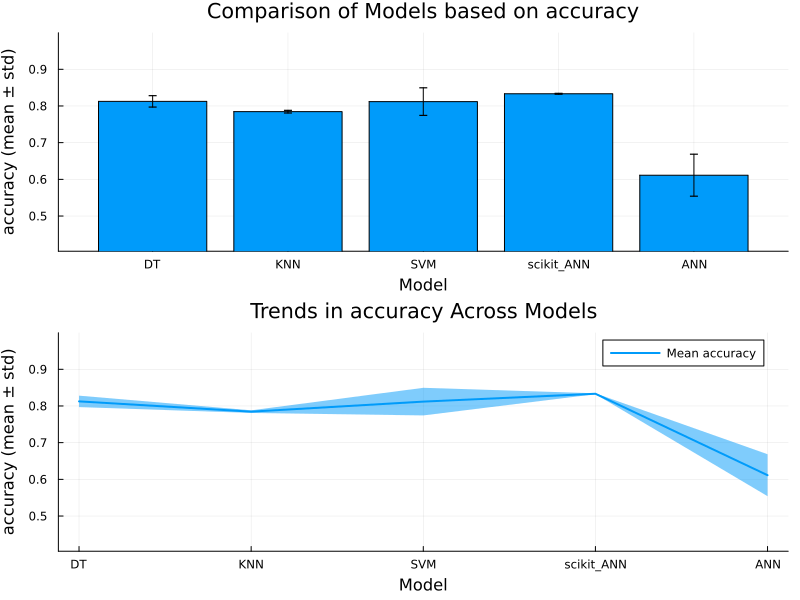

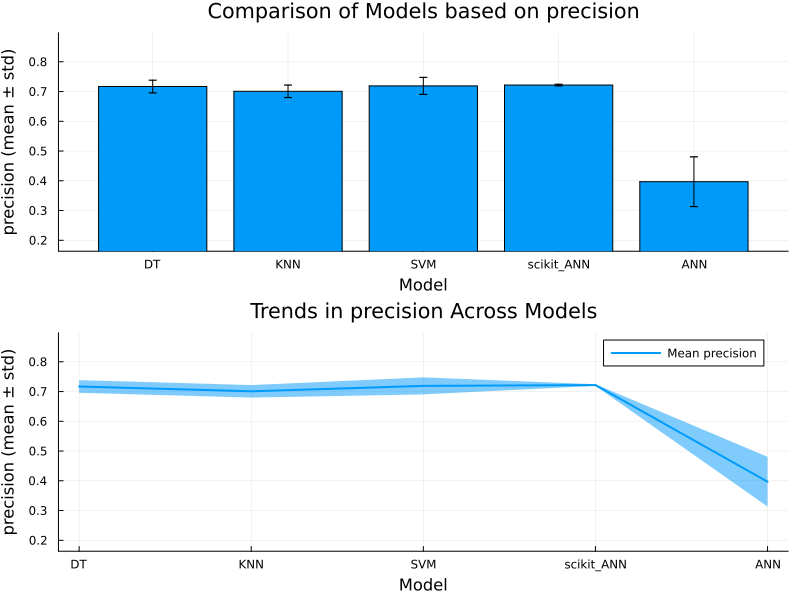

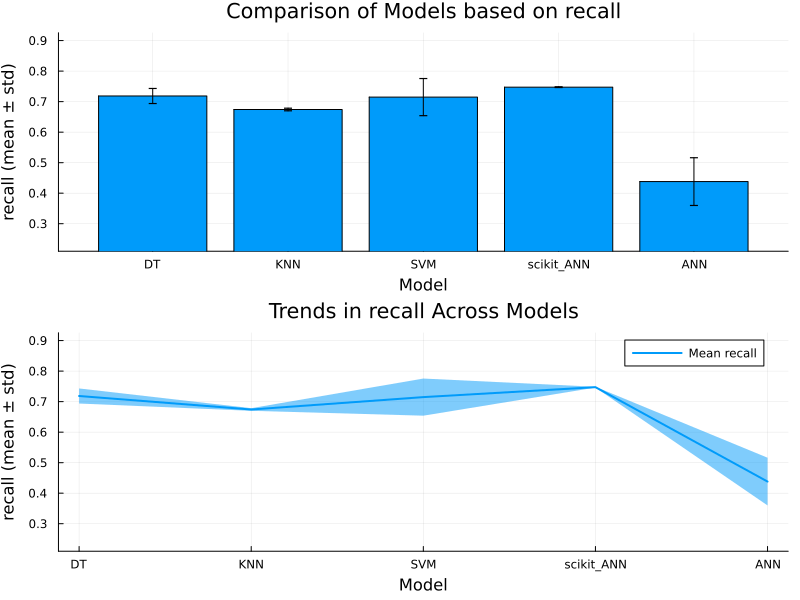

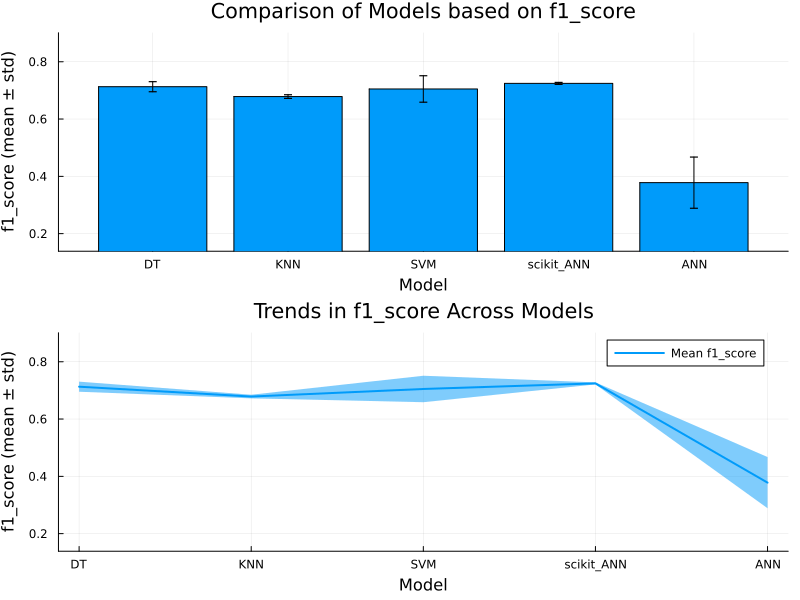

In [20]:
# Plot combined bar and line metrics
plotCombinedMetrics(model_names, metrics, metric_means, metric_stds, output_dir=plots_output_dir, show=true)

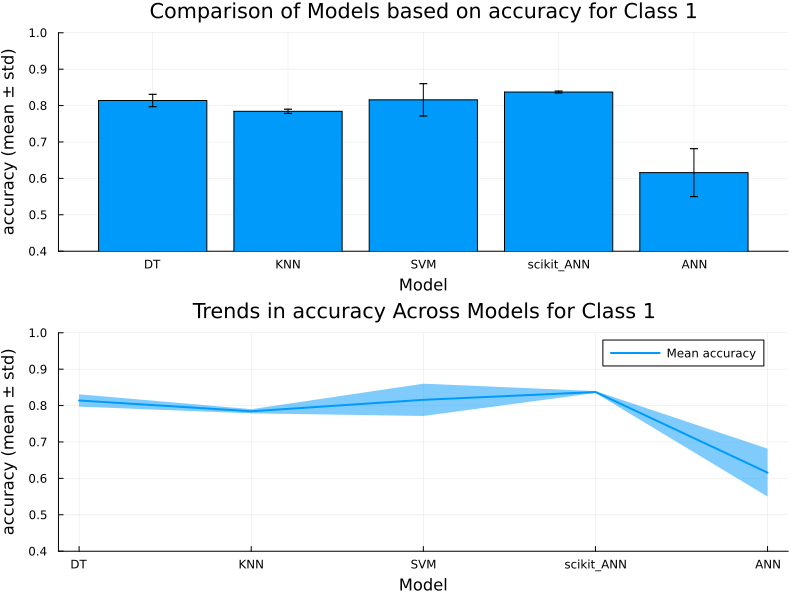

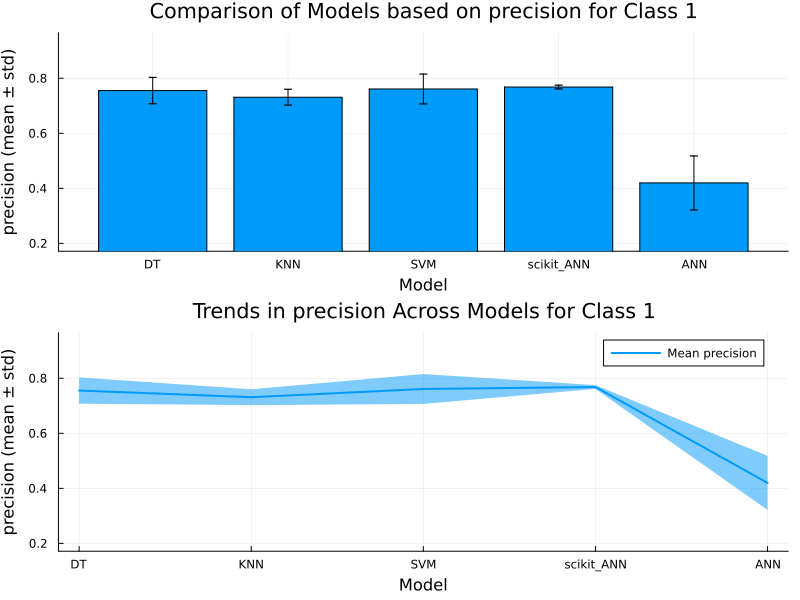

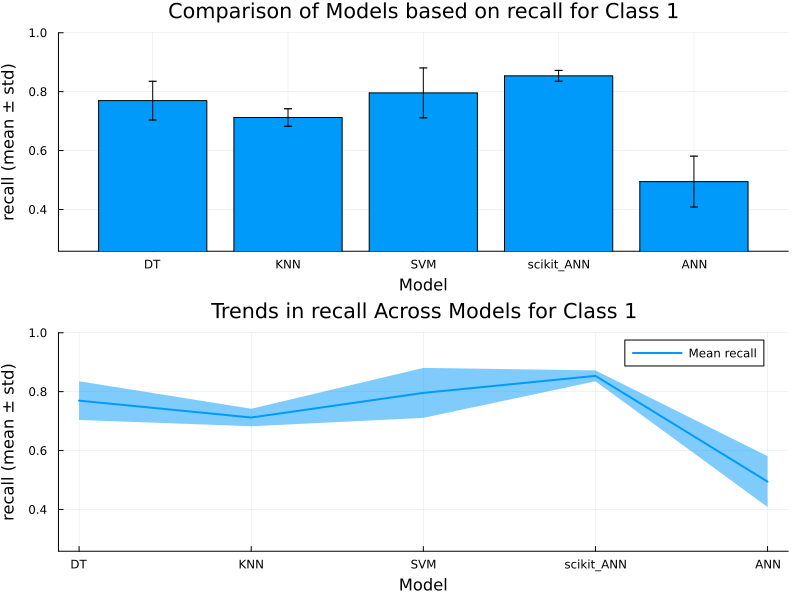

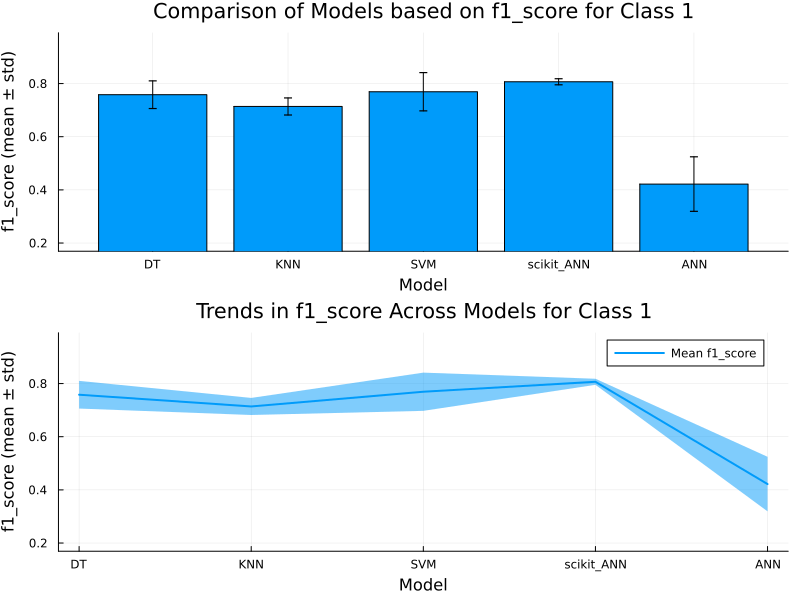

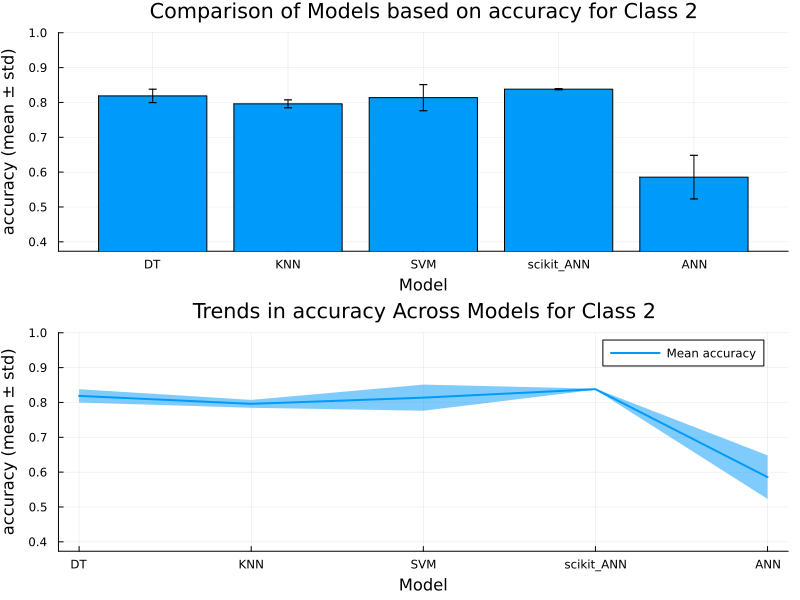

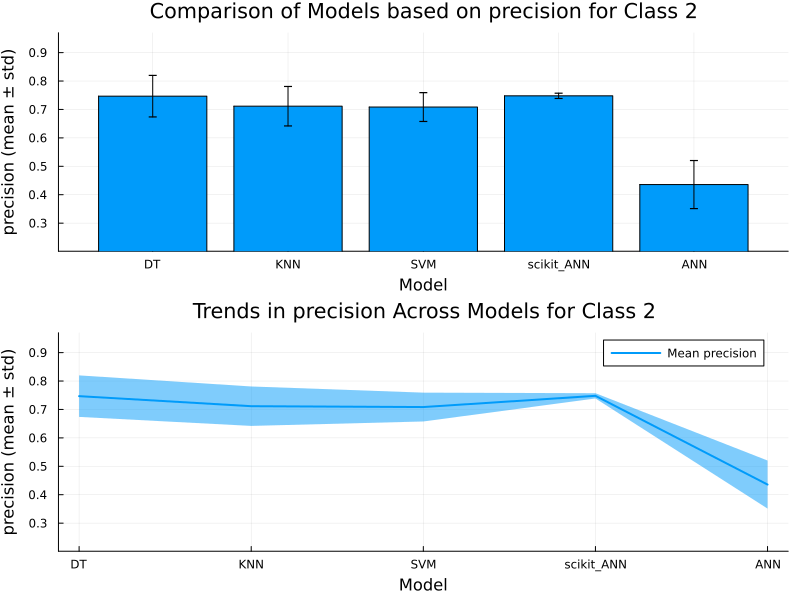

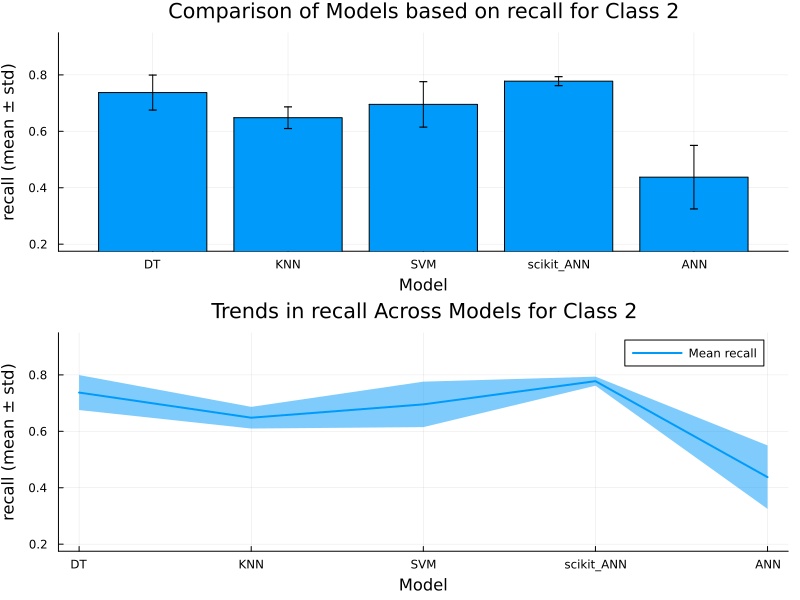

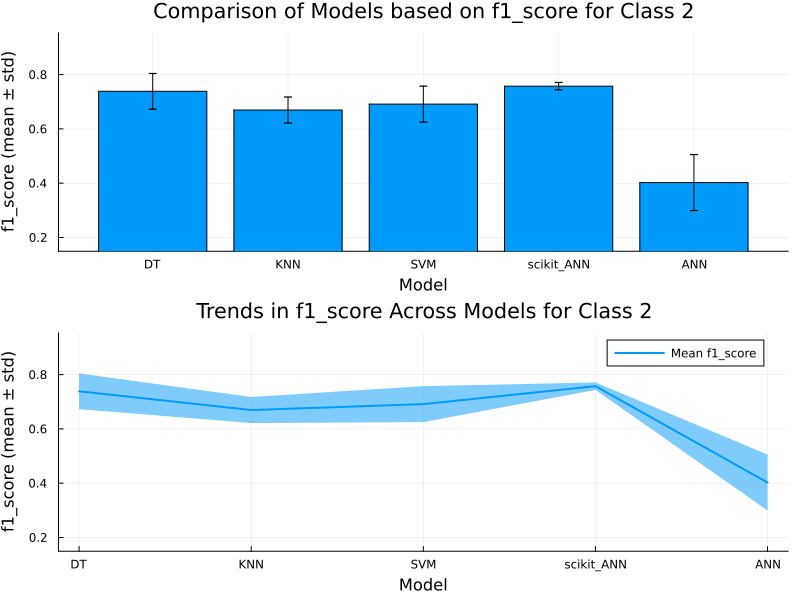

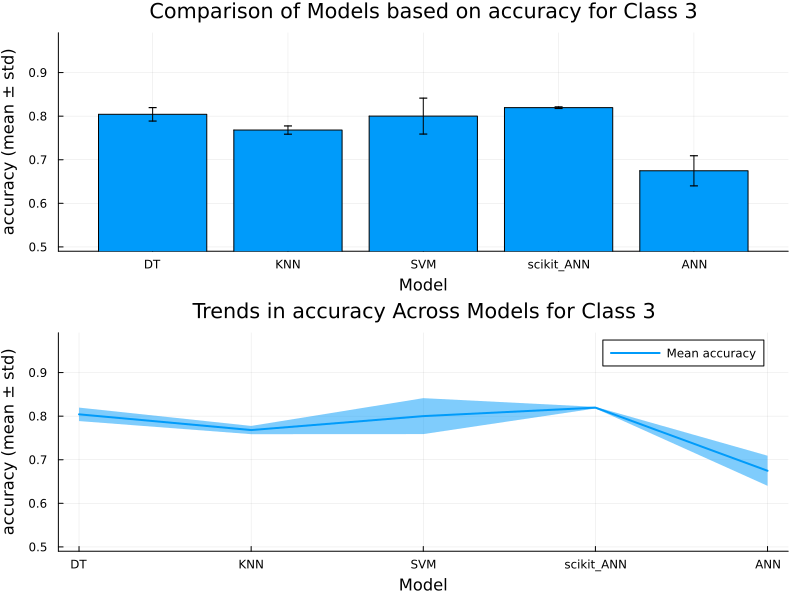

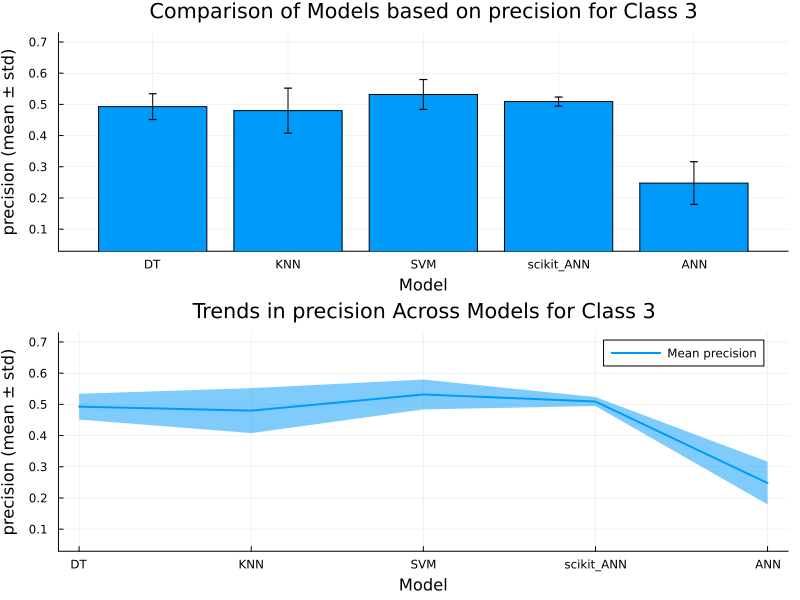

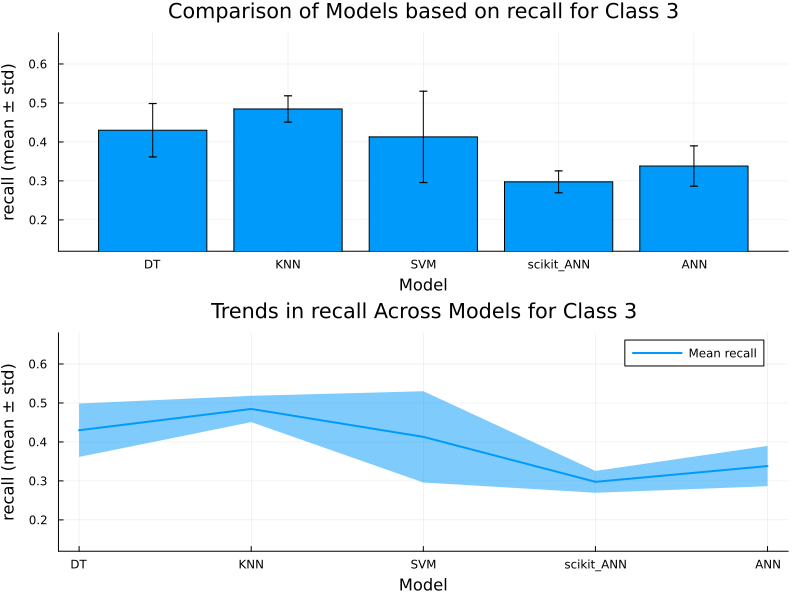

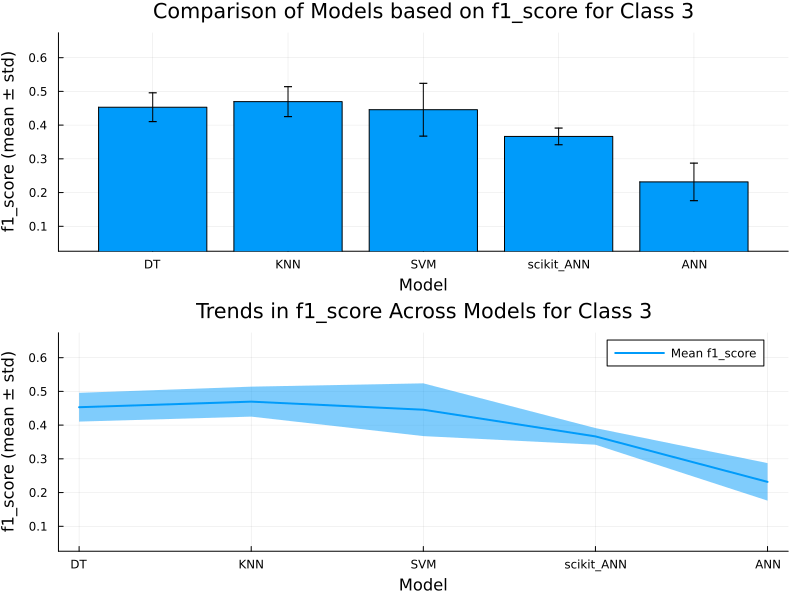

In [21]:
# Plot combined bar and line metrics per class
plotCombinedMetrics(model_names, 3, metrics, metric_means_class, metric_stds_class, output_dir=plots_output_dir, show=true)

In [9]:
# Generate and print the overall comparison table
generateComparisonTable(model_names, metrics, metric_maxes; output_dir=tables_output_dir, sort_by=:accuracy, rev=true)


Comparison of Metrics Across Models (Sorted by accuracy):
┌────────────┬──────────┬───────────┬────────┬──────────┐
│      Model │ Accuracy │ Precision │ Recall │ F1-Score │
├────────────┼──────────┼───────────┼────────┼──────────┤
│        SVM │     0.84 │     0.742 │   0.76 │    0.742 │
│ scikit_ANN │    0.835 │     0.727 │   0.75 │     0.73 │
│         DT │    0.832 │     0.747 │  0.752 │    0.734 │
│        KNN │    0.788 │     0.722 │  0.679 │    0.685 │
│        ANN │    0.696 │     0.544 │  0.554 │    0.522 │
└────────────┴──────────┴───────────┴────────┴──────────┘


In [10]:
# Generate and print the overall comparison table by class
generateComparisonTable(model_names, 3, metrics, metric_maxes_class; output_dir=tables_output_dir, sort_by=:accuracy, rev=true)


Comparison of Metrics Across Models for Class 1 (Sorted by accuracy):
┌────────────┬──────────┬───────────┬────────┬──────────┐
│      Model │ Accuracy │ Precision │ Recall │ F1-Score │
├────────────┼──────────┼───────────┼────────┼──────────┤
│        SVM │    0.847 │     0.803 │  0.872 │    0.822 │
│ scikit_ANN │    0.842 │     0.776 │  0.878 │     0.82 │
│         DT │    0.831 │     0.793 │  0.851 │    0.807 │
│        KNN │    0.791 │     0.772 │  0.766 │    0.763 │
│        ANN │    0.719 │     0.587 │  0.608 │    0.576 │
└────────────┴──────────┴───────────┴────────┴──────────┘

Comparison of Metrics Across Models for Class 2 (Sorted by accuracy):
┌────────────┬──────────┬───────────┬────────┬──────────┐
│      Model │ Accuracy │ Precision │ Recall │ F1-Score │
├────────────┼──────────┼───────────┼────────┼──────────┤
│        SVM │    0.849 │     0.793 │  0.846 │     0.81 │
│         DT │    0.848 │     0.825 │  0.787 │    0.796 │
│ scikit_ANN │    0.841 │     0.766 │  0.806 │

### Conclusions

In general, applying SMOTE did not yield better results compared to the first approach. Additionally, this approach resulted in extremely high variance for the ANN model, which is undesirable. The following figure illustrates the mean F1-scores for individual models:

<div style="display: flex; justify-content: center;">
  <image src="plots/Approach3/combined_f1_score_plots.png" width="50%"/>
</div>

To provide a clearer comparison, the tables below summarize the highest metric values achieved by each model in the first and third approaches:

**Table: Best Values per Model and Metric in the First Approach**
| Model | Accuracy | Precision | Recall | F1-score |
| ---------- | -------- | --------- | ------ | -------- |
| SVM | 0.855 | 0.769 | 0.78 | 0.767 |
| ANN | 0.854 | 0.761 | 0.776 | 0.764 |
| scikit_ANN | 0.853 | 0.763 | 0.776 | 0.765 |
| DT | 0.841 | 0.753 | 0.76 | 0.746 |
| KNN | 0.815 | 0.721 | 0.732 | 0.705 |

**Table: Best Values per Model and Metric in the Third Approach**
| Model | Accuracy | Precision | Recall | F1-score |
| ---------- | -------- | --------- | ------ | -------- |
| SVM | 0.849 | 0.768 | 0.772 | 0.759 |
| scikit_ANN | 0.845 | 0.745 | 0.764 | 0.746 |
| DT | 0.841 | 0.759 | 0.763 | 0.749 |
| ANN | 0.841 | 0.735 | 0.756 | 0.737 |
| KNN | 0.813 | 0.741 | 0.716 | 0.719 |

We observe that the differences between the tables are minimal, with the best F1-scores for the third approach being slightly lower than those of the first approach (except for KNN). This result suggests that the SMOTE algorithm did not significantly improve the models' performance. The high dimensionality of the dataset may have contributed to this outcome, as generating synthetic samples with SMOTE in high-dimensional spaces can be challenging.

The primary objective of this approach was to improve model performance for the third class, `Enrolled`, with the goal of achieving overall better performance. The following plots compare the F1-scores for the `Enrolled` class across the first and third approaches. While there was a slight improvement in the performance for Enrolled, this improvement came at the cost of a small decline in performance for the other classes.

<div style="display: flex; justify-content: center;">
  <image src="plots/Approach1/class_results/combined_f1_score_plots_class_3.png" width="40%"/>
  <image src="plots/Approach3/class_results/combined_f1_score_plots_class_3.png" width="40%"/>
</div>


## Ensemble models

After training the individual models, we will train an ensemble model with the three best models. The method used to combine the models will be:

- **Majority voting**
- **Weighted voting**
- **Stacking** (using a logistic regression as the meta-model)


In [11]:
# Select the best models
estimators = [:SVC, :DT, :KNN]
hyperparameters = Vector{Dict}([
  Dict(
  :kernel => "linear",
  :C => 0.1,
  :gamma => "auto",
  :probability => true,
  ),
  Dict(
    :max_depth => 5,
    :criterion => "gini",
    :min_samples_split => 2,
  ),
  Dict(
    :n_neighbors => 7,
    :weights => "uniform",
    :metric => "euclidean",
  )])

# Define ensembles
ensembles = [
  Dict(
    :type => :Voting,
    :hyperparameters => Dict(
    )
  ),
  Dict(
    :type => :Voting,
    :hyperparameters => Dict(
      :voting => "soft",
      :weights => [0.4, 0.4, 0.2]
    )
  ),
  Dict(
    :type => :Stacking,
    :hyperparameters => Dict(
      :final_estimator => LogisticRegression()
    )
  )
]

3-element Vector{Dict{Symbol, Any}}:
 Dict(:type => :Voting, :hyperparameters => Dict{Any, Any}())
 Dict(:type => :Voting, :hyperparameters => Dict{Symbol, Any}(:voting => "soft", :weights => [0.4, 0.4, 0.2]))
 Dict(:type => :Stacking, :hyperparameters => Dict{Symbol, PyCall.PyObject}(:final_estimator => PyObject LogisticRegression()))

In [13]:
smotePercentages = Dict("Enrolled" => 300)
smoteNeighbors = 5

for (index, ensemble) in enumerate(ensembles)
    println("Training ensemble ", ensemble[:type])
    metrics, class_results = trainClassEnsemble(
        estimators,
        hyperparameters,
        (inputs, targets),
        fold_indices;
        ensembleType = ensemble[:type],
        ensembleHyperParameters = ensemble[:hyperparameters],
        metricsToSave = metrics_to_save,
        verbose = false,
        repetitionsTraining = 5,
        applySmote=true,
        smotePercentages=smotePercentages,
        smoteNeighbors=smoteNeighbors
    )
    ensemble[:results] = metrics
    ensemble[:class_results] = class_results
    println("------------------------------------")
end

Training ensemble Voting
Mean accuracy: 0.83205 ± 0.0106
	Class 1: 0.83562 ± 0.02017
	Class 2: 0.84025 ± 0.02039
	Class 3: 0.81953 ± 0.01067
Mean precision: 0.72735 ± 0.01988
	Class 1: 0.78945 ± 0.03525
	Class 2: 0.77204 ± 0.01879
	Class 3: 0.49631 ± 0.04883
Mean recall: 0.7477 ± 0.01591
	Class 1: 0.83469 ± 0.12059
	Class 2: 0.82508 ± 0.10446
	Class 3: 0.27524 ± 0.05061
Mean f1_score: 0.72704 ± 0.01619
	Class 1: 0.80602 ± 0.04617
	Class 2: 0.79494 ± 0.04767
	Class 3: 0.35221 ± 0.04901
------------------------------------
Training ensemble Voting
Mean accuracy: 0.83279 ± 0.00881
	Class 1: 0.83354 ± 0.02237
	Class 2: 0.8453 ± 0.02126
	Class 3: 0.82053 ± 0.00906
Mean precision: 0.72263 ± 0.01776
	Class 1: 0.77347 ± 0.02732
	Class 2: 0.77798 ± 0.02167
	Class 3: 0.49724 ± 0.05983
Mean recall: 0.74968 ± 0.01183
	Class 1: 0.85916 ± 0.11257
	Class 2: 0.83752 ± 0.10165
	Class 3: 0.20473 ± 0.04725
Mean f1_score: 0.71969 ± 0.01464
	Class 1: 0.80964 ± 0.03956
	Class 2: 0.80346 ± 0.03933
	Class 3: 

In [14]:
results_folder = "results/"
if !isdir(results_folder)
  mkdir(results_folder)
end

filename = results_folder * "3_ensemble_results.jl"

# Create a dictionary with the results of ANN, DT, SVM, and KNN
obj = Dict(
  :Voting_Hard => Dict(
    "general_results" => ensembles[1][:results],
    "class_results" => ensembles[1][:class_results]
  ),
  :Voting_Soft => Dict(
    "general_results" => ensembles[2][:results],
    "class_results" => ensembles[2][:class_results]
  ),
  :Stacking => Dict(
    "general_results" => ensembles[3][:results],
    "class_results" => ensembles[3][:class_results]
  )
)

# Save the results
open(filename, "w") do file
  serialize(file, obj)
end

### Ensemble model plots

In [15]:
filename = results_folder * "3_ensemble_results.jl"

# Load the results
loaded_obj = open(filename, "r") do file
  deserialize(file)
end

model_names, metrics, metric_means, metric_stds, metric_means_class, metric_stds_class, metric_maxes, metric_maxes_class = aggregateMetrics(loaded_obj, 3, ensemble=true)
plots_output_dir = "./plots/Approach3/ensembles"
tables_output_dir = "./tables/Approach3/ensembles"

"./tables/Approach3/ensembles"

In [ ]:
plotCombinedMetrics(model_names, metrics, metric_means, metric_stds, output_dir=plots_output_dir, show=true)

In [ ]:
plotCombinedMetrics(model_names, 3, metrics, metric_means_class, metric_stds_class, output_dir=plots_output_dir, show=true)

In [16]:
generateComparisonTable(model_names, metrics, metric_means; output_dir=tables_output_dir, sort_by=:f1_score, rev=true)


Comparison of Metrics Across Models (Sorted by f1_score):
┌─────────────┬──────────┬───────────┬────────┬──────────┐
│       Model │ Accuracy │ Precision │ Recall │ F1-Score │
├─────────────┼──────────┼───────────┼────────┼──────────┤
│ Voting_Hard │    0.832 │     0.727 │  0.748 │    0.727 │
│ Voting_Soft │    0.833 │     0.723 │   0.75 │     0.72 │
│    Stacking │    0.834 │     0.707 │  0.748 │    0.703 │
└─────────────┴──────────┴───────────┴────────┴──────────┘


In [17]:
generateComparisonTable(model_names, 3, metrics, metric_means_class; output_dir=tables_output_dir, sort_by=:f1_score, rev=true)


Comparison of Metrics Across Models for Class 1 (Sorted by f1_score):
┌─────────────┬──────────┬───────────┬────────┬──────────┐
│       Model │ Accuracy │ Precision │ Recall │ F1-Score │
├─────────────┼──────────┼───────────┼────────┼──────────┤
│    Stacking │    0.837 │      0.76 │  0.884 │    0.817 │
│ Voting_Soft │    0.834 │     0.773 │  0.859 │     0.81 │
│ Voting_Hard │    0.836 │     0.789 │  0.835 │    0.806 │
└─────────────┴──────────┴───────────┴────────┴──────────┘

Comparison of Metrics Across Models for Class 2 (Sorted by f1_score):
┌─────────────┬──────────┬───────────┬────────┬──────────┐
│       Model │ Accuracy │ Precision │ Recall │ F1-Score │
├─────────────┼──────────┼───────────┼────────┼──────────┤
│    Stacking │    0.843 │     0.752 │  0.869 │    0.806 │
│ Voting_Soft │    0.845 │     0.778 │  0.838 │    0.803 │
│ Voting_Hard │     0.84 │     0.772 │  0.825 │    0.795 │
└─────────────┴──────────┴───────────┴────────┴──────────┘

Comparison of Metrics Across Mo